In [44]:
# API key ID: otlwwfxero72fkms03hi49x2
# API key secret: 5qbnpzqphl1y8bz6eggxraxlzlnbnhso49bro4925r1rpxj6sn
# app token: 8y23ArYxg4pcvOMgWzMFSC0nB
# secret app token: pZgwEL4lKm2r1s868Saz3EJ1ebpTKy-FzglU

# crime data docs: https://dev.socrata.com/foundry/data.cityofchicago.org/9hwr-2zxp

# make sure to install these packages before running:
!pip install pandas
!pip install sodapy
!pip install category_encoders

In [45]:
import pandas as pd
import sodapy
from sodapy import Socrata
import statistics
pd.set_option('display.max_columns', 500)

In [46]:
# crime_url = "https://data.cityofchicago.org/resource/9hwr-2zxp.json"


app_token = "8y23ArYxg4pcvOMgWzMFSC0nB"

# Example authenticated client (needed for non-public datasets):
client = Socrata("data.cityofchicago.org",
                 app_token, 
                 username="ch35@illinois.edu",
                 password="68M8rz3vF!StBjD")


# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("9hwr-2zxp", limit = 250000)

# Convert to pandas DataFrame
crime_df = pd.DataFrame.from_records(results)

print(crime_df.shape)

(216249, 22)


# Logistic Regression

In [47]:
crime_df.head()

,date,location,district,block,y_coordinate,latitude,description,location_description,updated_on,community_area,iucr,x_coordinate,ward,case_number,year,domestic,fbi_code,longitude,beat,primary_type,arrest,id
0,2022-12-01T23:51:00.000,"{'latitude': '41.794066169', 'human_address': ...",007,005XX W GARFIELD BLVD,1868314,41.794066169,UNLAWFUL USE - OTHER DANGEROUS WEAPON,STREET,2022-12-08T15:48:51.000,68,141C,1173729,20,JF494955,2022,False,15,-87.638477275,0711,WEAPONS VIOLATION,True,12909896
1,2022-12-01T23:45:00.000,"{'latitude': '41.882435247', 'human_address': ...",011,001XX N KILDARE AVE,1900321,41.882435247,SIMPLE,APARTMENT,2022-12-08T15:48:51.000,26,0560,1147707,28,JF494919,2022,False,08A,-87.733079304,1114,ASSAULT,False,12909799
2,2022-12-01T23:45:00.000,"{'latitude': '41.86640116', 'human_address': '...",011,032XX W ROOSEVELT RD,1894531,41.86640116,$500 AND UNDER,RESTAURANT,2022-12-08T15:48:51.000,29,0820,1155131,24,JF494917,2022,False,06,-87.705973505,1134,THEFT,False,12909816
3,2022-12-01T23:45:00.000,"{'latitude': '41.765320781', 'human_address': ...",003,071XX S LANGLEY AVE,1857908,41.765320781,UNLAWFUL POSSESSION - HANDGUN,STREET,2022-12-08T15:48:51.000,69,143A,1182125,6,JF494922,2022,False,15,-87.60801171,0323,WEAPONS VIOLATION,True,12909802
4,2022-12-01T23:41:00.000,"{'latitude': '41.804831971', 'human_address': ...",009,049XX S WINCHESTER AVE,1872162,41.804831971,RESIST / OBSTRUCT / DISARM OFFICER,STREET,2022-12-08T15:48:51.000,61,3710,1164182,15,JF494991,2022,False,24,-87.673377333,0931,INTERFERENCE WITH PUBLIC OFFICER,True,12909856


In [48]:
#creating variable for month
month = [i[0:7] for i in crime_df.date]

In [49]:
#adding to data frame
crime_df["month"] = month

In [50]:
#dropping irrelevant variables
crime_df_clean = crime_df.drop(["date", "location", "block", "updated_on", "case_number", "year", "id"], axis = 1)
crime_df_clean.head()

,district,y_coordinate,latitude,description,location_description,community_area,iucr,x_coordinate,ward,domestic,fbi_code,longitude,beat,primary_type,arrest,month
0,007,1868314,41.794066169,UNLAWFUL USE - OTHER DANGEROUS WEAPON,STREET,68,141C,1173729,20,False,15,-87.638477275,0711,WEAPONS VIOLATION,True,2022-12
1,011,1900321,41.882435247,SIMPLE,APARTMENT,26,0560,1147707,28,False,08A,-87.733079304,1114,ASSAULT,False,2022-12
2,011,1894531,41.86640116,$500 AND UNDER,RESTAURANT,29,0820,1155131,24,False,06,-87.705973505,1134,THEFT,False,2022-12
3,003,1857908,41.765320781,UNLAWFUL POSSESSION - HANDGUN,STREET,69,143A,1182125,6,False,15,-87.60801171,0323,WEAPONS VIOLATION,True,2022-12
4,009,1872162,41.804831971,RESIST / OBSTRUCT / DISARM OFFICER,STREET,61,3710,1164182,15,False,24,-87.673377333,0931,INTERFERENCE WITH PUBLIC OFFICER,True,2022-12


## Removing Categorical Variables with High Cardinality (50+ Levels)

In [51]:
crime_df_clean.dtypes

district                object
y_coordinate            object
latitude                object
description             object
location_description    object
community_area          object
iucr                    object
x_coordinate            object
ward                    object
domestic                  bool
fbi_code                object
longitude               object
beat                    object
primary_type            object
arrest                    bool
month                   object
dtype: object

In [52]:
#converting variables to numeric
num_vars = ["y_coordinate", "x_coordinate", "latitude", "longitude"]
for i in num_vars:
    crime_df_clean[i] = crime_df_clean[i].astype("float")
crime_df_clean.dtypes

district                 object
y_coordinate            float64
latitude                float64
description              object
location_description     object
community_area           object
iucr                     object
x_coordinate            float64
ward                     object
domestic                   bool
fbi_code                 object
longitude               float64
beat                     object
primary_type             object
arrest                     bool
month                    object
dtype: object

In [53]:
#converting boolean variables to binary categorical variables
crime_df_clean["domestic"] = crime_df_clean["domestic"].astype(int)
crime_df_clean["arrest"] = crime_df_clean["arrest"].astype(int)
crime_df_clean.dtypes

district                 object
y_coordinate            float64
latitude                float64
description              object
location_description     object
community_area           object
iucr                     object
x_coordinate            float64
ward                     object
domestic                  int64
fbi_code                 object
longitude               float64
beat                     object
primary_type             object
arrest                    int64
month                    object
dtype: object

In [54]:
crime_df_clean["arrest"].dtypes == "O"

False

In [55]:
#storing list of cateogorical variables with high cardinality
high_card = [var for var in crime_df_clean.columns if len(crime_df_clean[var].value_counts()) >= 50 and crime_df_clean[var].dtypes == "O"]
high_card

['description',
 'location_description',
 'community_area',
 'iucr',
 'ward',
 'beat']

In [56]:
#dropping from set
crime_df_new = crime_df_clean.drop(high_card, axis = 1)
crime_df_new.head()

,district,y_coordinate,latitude,x_coordinate,domestic,fbi_code,longitude,primary_type,arrest,month
0,007,1868314.0,41.794066,1173729.0,0,15,-87.638477,WEAPONS VIOLATION,1,2022-12
1,011,1900321.0,41.882435,1147707.0,0,08A,-87.733079,ASSAULT,0,2022-12
2,011,1894531.0,41.866401,1155131.0,0,06,-87.705974,THEFT,0,2022-12
3,003,1857908.0,41.765321,1182125.0,0,15,-87.608012,WEAPONS VIOLATION,1,2022-12
4,009,1872162.0,41.804832,1164182.0,0,24,-87.673377,INTERFERENCE WITH PUBLIC OFFICER,1,2022-12


## Binning Categorical Variables
#### Goal is to group levels together if they share a similar target rate to establish bin credibility (at least 1% of observations in each bin)

In [57]:
cat_vars = [var for var in crime_df_new.columns if crime_df_new[var].dtypes == "O"]
cat_vars

['district', 'fbi_code', 'primary_type', 'month']

In [58]:
#district
pd.DataFrame({"District": crime_df_new["district"].value_counts().index, "Target Rate": [round(statistics.mean(crime_df_new["arrest"].loc[crime_df_new["district"] == i]), 3) for i in crime_df_new["district"].value_counts().index], "Proportion": [round(crime_df_new.loc[crime_df_new["district"] == i].shape[0] / crime_df_new.shape[0], 3) for i in crime_df_new["district"].value_counts().index]}).sort_values(by = "Target Rate")
                                                                                                                                                                                                                               

,District,Target Rate,Proportion
22,16,0.000,0.000
7,019,0.072,0.051
2,012,0.081,0.060
21,020,0.087,0.021
10,002,0.087,0.049
0,008,0.090,0.062
8,003,0.090,0.050
3,004,0.092,0.059
19,022,0.098,0.032
16,024,0.098,0.035


##### Decision: 16 + 019, 011 + 031, all others can remain on their own

In [59]:
#FBI Code
pd.DataFrame({"FBI Code": crime_df_new["fbi_code"].value_counts().index, "Target Rate": [round(statistics.mean(crime_df_new["arrest"].loc[crime_df_new["fbi_code"] == i]), 3) for i in crime_df_new["fbi_code"].value_counts().index], "Proportion": [round(crime_df_new.loc[crime_df_new["fbi_code"] == i].shape[0] / crime_df_new.shape[0], 3) for i in crime_df_new["fbi_code"].value_counts().index]}).sort_values(by = "Target Rate")
                                                                                                                                                                                                                               

,FBI Code,Target Rate,Proportion
13,10,0.007,0.010
6,11,0.013,0.053
3,07,0.025,0.087
14,02,0.026,0.007
2,14,0.031,0.115
0,06,0.035,0.232
10,05,0.038,0.032
8,03,0.047,0.037
4,08A,0.055,0.075
15,17,0.055,0.007


##### Decision: Variable incredibly similar to the variable below, we'll drop this one

In [60]:
crime_df_new = crime_df_new.drop(["fbi_code"], axis = 1)
crime_df_new.head()

,district,y_coordinate,latitude,x_coordinate,domestic,longitude,primary_type,arrest,month
0,007,1868314.0,41.794066,1173729.0,0,-87.638477,WEAPONS VIOLATION,1,2022-12
1,011,1900321.0,41.882435,1147707.0,0,-87.733079,ASSAULT,0,2022-12
2,011,1894531.0,41.866401,1155131.0,0,-87.705974,THEFT,0,2022-12
3,003,1857908.0,41.765321,1182125.0,0,-87.608012,WEAPONS VIOLATION,1,2022-12
4,009,1872162.0,41.804832,1164182.0,0,-87.673377,INTERFERENCE WITH PUBLIC OFFICER,1,2022-12


In [61]:
#Primary Type
pd.DataFrame({"Primary Type": crime_df_new["primary_type"].value_counts().index, "Target Rate": [round(statistics.mean(crime_df_new["arrest"].loc[crime_df_new["primary_type"] == i]), 3) for i in crime_df_new["primary_type"].value_counts().index], "Proportion": [round(crime_df_new.loc[crime_df_new["primary_type"] == i].shape[0] / crime_df_new.shape[0], 3) for i in crime_df_new["primary_type"].value_counts().index]}).sort_values(by = "Target Rate")
                                                                                                                                                                                                                               

,Primary Type,Target Rate,Proportion
26,HUMAN TRAFFICKING,0.000,0.000
23,INTIMIDATION,0.006,0.001
5,DECEPTIVE PRACTICE,0.015,0.063
13,CRIMINAL SEXUAL ASSAULT,0.025,0.007
4,MOTOR VEHICLE THEFT,0.025,0.087
2,CRIMINAL DAMAGE,0.031,0.115
0,THEFT,0.035,0.232
9,BURGLARY,0.038,0.032
8,ROBBERY,0.047,0.037
12,OFFENSE INVOLVING CHILDREN,0.051,0.008


##### Decision: Bottom 5, Next 5, Next 7, Next 2, Next 5, Last 7

In [62]:
#Month
pd.DataFrame({"Month": crime_df_new["month"].value_counts().index, "Target Rate": [round(statistics.mean(crime_df_new["arrest"].loc[crime_df_new["month"] == i]), 3) for i in crime_df_new["month"].value_counts().index], "Proportion": [round(crime_df_new.loc[crime_df_new["month"] == i].shape[0] / crime_df_new.shape[0], 3) for i in crime_df_new["month"].value_counts().index]}).sort_values(by = "Target Rate")
                                                                                                                                                                                                                               

,Month,Target Rate,Proportion
6,2022-11,0.086,0.092
0,2022-10,0.091,0.105
3,2022-09,0.102,0.102
1,2022-07,0.104,0.102
2,2022-08,0.105,0.102
11,2022-12,0.106,0.003
9,2022-01,0.112,0.071
4,2022-06,0.118,0.095
7,2022-03,0.122,0.084
8,2022-04,0.130,0.082


##### Decision: Bins good to remain on their own, may consider seasonal binning later

### Implementing Bins

In [63]:
#district
crime_df_new.loc[crime_df_new["district"].isin(["16", "019"]), "district"] = "16/019"
crime_df_new.loc[crime_df_new["district"].isin(["011", "031"]), "district"] = "011/031"

In [64]:
#checking new values
pd.DataFrame({"District": crime_df_new["district"].value_counts().index, "Target Rate": [round(statistics.mean(crime_df_new["arrest"].loc[crime_df_new["district"] == i]), 3) for i in crime_df_new["district"].value_counts().index], "Proportion": [round(crime_df_new.loc[crime_df_new["district"] == i].shape[0] / crime_df_new.shape[0], 3) for i in crime_df_new["district"].value_counts().index]}).sort_values(by = "Target Rate")
                                                                                                                                                                                                                               

,District,Target Rate,Proportion
7,16/019,0.072,0.051
2,012,0.081,0.060
10,002,0.087,0.049
21,020,0.087,0.021
0,008,0.090,0.062
8,003,0.090,0.050
3,004,0.092,0.059
19,022,0.098,0.032
16,024,0.098,0.035
18,014,0.102,0.034


In [65]:
#Primary Type
crime_df_new.loc[crime_df_new["primary_type"].isin(["HUMAN TRAFFICKING", "INTIMIDATION", "DECEPTIVE PRACTICE", "CRIMINAL SEXUAL ASSAULT", "MOTOR VEHICLE THEFT"]), "primary_type"] = "bin1"
crime_df_new.loc[crime_df_new["primary_type"].isin(["CRIMINAL DAMAGE", "THEFT", "BURGLARY", "STALKING", "ROBBERY"]), "primary_type"] = "bin2"
crime_df_new.loc[crime_df_new["primary_type"].isin(["OFFENSE INVOLVING CHILDREN", "SEX OFFENSE", "ARSON", "KIDNAPPING", "ASSAULT", "BATTERY", "OTHER OFFENSE"]), "primary_type"] = "bin3"
crime_df_new.loc[crime_df_new["primary_type"].isin(["HOMICIDE", "CRIMINAL TRESPASS"]), "primary_type"] = "bin4"
crime_df_new.loc[crime_df_new["primary_type"].isin(["OTHER NARCOTIC VIOLATION", "PUBLIC PEACE VIOLATION", "NON-CRIMINAL", "WEAPONS VIOLATION", "OBSCENITY"]), "primary_type"] = "bin5"
crime_df_new.loc[crime_df_new["primary_type"].isin(["PUBLIC INDECENCY", "GAMBLING", "INTERFERENCE WITH PUBLIC OFFICER", "NARCOTICS", "CONCEALED CARRY LICENSE VIOLATION", "LIQUOR LAW VIOLATION", "PROSTITUTION"]), "primary_type"] = "bin6"


In [66]:
#checking new values
pd.DataFrame({"Primary Type": crime_df_new["primary_type"].value_counts().index, "Target Rate": [round(statistics.mean(crime_df_new["arrest"].loc[crime_df_new["primary_type"] == i]), 3) for i in crime_df_new["primary_type"].value_counts().index], "Proportion": [round(crime_df_new.loc[crime_df_new["primary_type"] == i].shape[0] / crime_df_new.shape[0], 3) for i in crime_df_new["primary_type"].value_counts().index]}).sort_values(by = "Target Rate")
                                                                                                                                                                                                                               

,Primary Type,Target Rate,Proportion
2,bin1,0.021,0.157
0,bin2,0.035,0.418
1,bin3,0.125,0.341
5,bin4,0.291,0.021
3,bin5,0.606,0.041
4,bin6,0.946,0.022


## WoE (Weight of Evidence) Coding Categorical Variables
### Converts categoricals to numerics to allow their use in the model

In [67]:
#dropping na values
crime_df_new = crime_df_new.dropna()

In [68]:
#train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(crime_df_new.drop(["arrest"], axis = 1), crime_df_new["arrest"], shuffle=True)

In [69]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(161057, 8)
(53686, 8)
(161057,)
(53686,)


In [70]:
#making sure overall target rates are the same
print(statistics.mean(y_train.astype(int)))
print(statistics.mean(y_test.astype(int)))

0.11259367801461595
0.1124501732295198


In [71]:
#variables to be woe coded
cat_vars_new = [var for var in crime_df_new if crime_df_new[var].dtypes == "O" or var == "domestic"]
cat_vars_new

['district', 'domestic', 'primary_type', 'month']

In [72]:
import category_encoders as ce

In [73]:
#implementing woe coding
woe = ce.WOEEncoder(cols = cat_vars_new)
woe.fit(X_train, y_train)
train_woe = woe.transform(X_train, y_train)
test_woe = woe.transform(X_test)

In [74]:
train_woe.head()

,district,y_coordinate,latitude,x_coordinate,domestic,longitude,primary_type,month
205913,-0.100431,1854374.0,41.755924,1168669.0,0.111713,-87.657434,0.117022,-0.015511
16312,-0.352702,1900033.0,41.881179,1170421.0,-0.026231,-87.649682,-1.833294,-0.281699
31835,-0.100431,1846450.0,41.733977,1177831.0,-0.026231,-87.624097,-1.833294,-0.219467
198590,0.026261,1863031.0,41.779583,1173121.0,-0.026231,-87.640863,-1.223692,0.235654
10638,-0.056636,1887007.0,41.845324,1175391.0,-0.026231,-87.631823,2.519053,-0.281699


In [75]:
test_woe.head()

,district,y_coordinate,latitude,x_coordinate,domestic,longitude,primary_type,month
27334,-0.260752,1858322.0,41.766162,1194486.0,0.111713,-87.562692,0.117022,-0.219467
65401,-0.204571,1854740.0,41.756528,1186365.0,-0.026231,-87.592571,2.519053,-0.058710
88436,-0.204571,1852855.0,41.751134,1195557.0,0.111713,-87.558947,0.117022,-0.101866
43261,-0.260752,1856699.0,41.761678,1195711.0,-0.026231,-87.558256,-1.223692,-0.111061
104971,-0.100431,1852405.0,41.750255,1180622.0,0.111713,-87.613689,0.117022,-0.101866


## Univariate Screening
#### Generating univariate models to see which are predictive on their own

In [76]:
variables = train_woe.columns
import statsmodels.api as sm
from sklearn import metrics

In [77]:
#getting AUC for each individual variable
AUC = []
count = 0
for i in variables:
    mod = sm.GLM(y_train, train_woe[i], family=sm.families.Binomial()).fit()
    pred = mod.predict(test_woe[i])
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
    AUC.append(metrics.auc(fpr, tpr))

In [78]:
#displaying AUCs alongside their predictor
pd.DataFrame({"Predictor": train_woe.columns, "AUC": AUC})

,Predictor,AUC
0,district,0.581569
1,y_coordinate,0.499190
2,latitude,0.499020
3,x_coordinate,0.542045
4,domestic,0.513550
5,longitude,0.457588
6,primary_type,0.810111
7,month,0.548474


### Based on the above results, we will look at 3 models:
#### Full Model
#### Model with all AUCs above .5 (significant features only)
#### Model with only location information

In [94]:
#sets for significant features model
train_woe_2 = train_woe.drop(["longitude", "y_coordinate", "latitude"], axis = 1)
test_woe_2 = test_woe.drop(["longitude", "y_coordinate", "latitude"], axis = 1)

In [95]:
#sets for location features model
train_woe_3 = train_woe.drop(["domestic", "primary_type", "month"], axis = 1)
test_woe_3 = test_woe.drop(["domestic", "primary_type", "month"], axis = 1)

In [80]:
train_woe_2.head()

,district,x_coordinate,domestic,primary_type,month
205913,-0.100431,1168669.0,0.111713,0.117022,-0.015511
16312,-0.352702,1170421.0,-0.026231,-1.833294,-0.281699
31835,-0.100431,1177831.0,-0.026231,-1.833294,-0.219467
198590,0.026261,1173121.0,-0.026231,-1.223692,0.235654
10638,-0.056636,1175391.0,-0.026231,2.519053,-0.281699


In [81]:
test_woe_2.head()

,district,x_coordinate,domestic,primary_type,month
27334,-0.260752,1194486.0,0.111713,0.117022,-0.219467
65401,-0.204571,1186365.0,-0.026231,2.519053,-0.058710
88436,-0.204571,1195557.0,0.111713,0.117022,-0.101866
43261,-0.260752,1195711.0,-0.026231,-1.223692,-0.111061
104971,-0.100431,1180622.0,0.111713,0.117022,-0.101866


In [96]:
train_woe_3.head()

,district,y_coordinate,latitude,x_coordinate,longitude
205913,-0.100431,1854374.0,41.755924,1168669.0,-87.657434
16312,-0.352702,1900033.0,41.881179,1170421.0,-87.649682
31835,-0.100431,1846450.0,41.733977,1177831.0,-87.624097
198590,0.026261,1863031.0,41.779583,1173121.0,-87.640863
10638,-0.056636,1887007.0,41.845324,1175391.0,-87.631823


In [97]:
test_woe_3.head()

,district,y_coordinate,latitude,x_coordinate,longitude
27334,-0.260752,1858322.0,41.766162,1194486.0,-87.562692
65401,-0.204571,1854740.0,41.756528,1186365.0,-87.592571
88436,-0.204571,1852855.0,41.751134,1195557.0,-87.558947
43261,-0.260752,1856699.0,41.761678,1195711.0,-87.558256
104971,-0.100431,1852405.0,41.750255,1180622.0,-87.613689


## Constructing Model 1 (Full Model)

In [104]:
mod1 = sm.GLM(y_train, train_woe, family=sm.families.Binomial()).fit()
pred1 = mod1.predict(test_woe)
fpr1, tpr1, thresholds = metrics.roc_curve(y_test, pred1)
metrics.auc(fpr1, tpr1)

0.8238483603387761

### ROC Curve

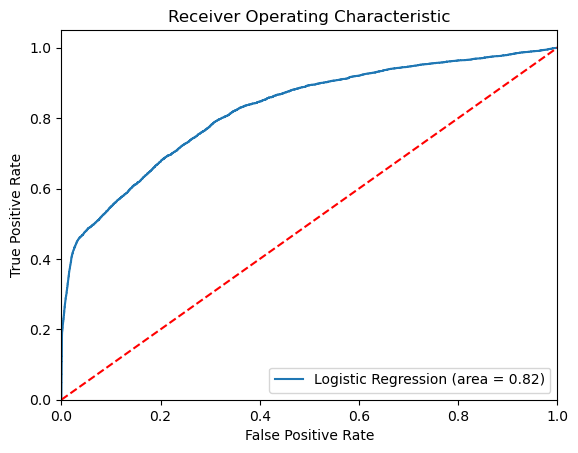

In [106]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr1, tpr1, label='Logistic Regression (area = %0.2f)' % metrics.auc(fpr1, tpr1))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Constructing Model 2 (Significant AUC Model)

In [107]:
mod2 = sm.GLM(y_train, train_woe_2, family=sm.families.Binomial()).fit()
pred2 = mod2.predict(test_woe_2)
fpr2, tpr2, thresholds = metrics.roc_curve(y_test, pred2)
metrics.auc(fpr2, tpr2)

0.8204928398529954

### ROC Curve

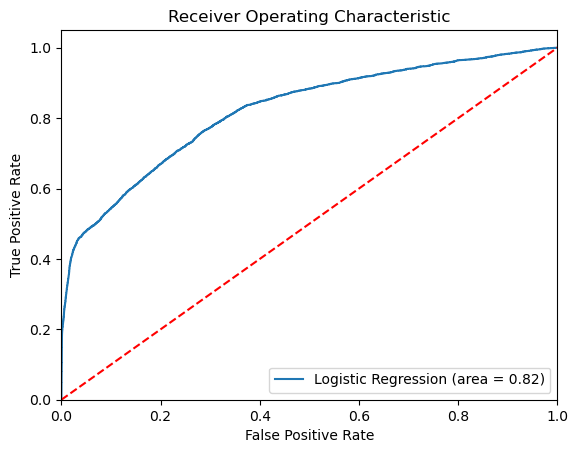

In [108]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr2, tpr2, label='Logistic Regression (area = %0.2f)' % metrics.auc(fpr2, tpr2))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Constructing Model 3 (Location Model)

In [109]:
mod3 = sm.GLM(y_train, train_woe_3, family=sm.families.Binomial()).fit()
pred3 = mod3.predict(test_woe_3)
fpr3, tpr3, thresholds = metrics.roc_curve(y_test, pred3)
metrics.auc(fpr3, tpr3)

0.5823257609923106

### ROC Curve

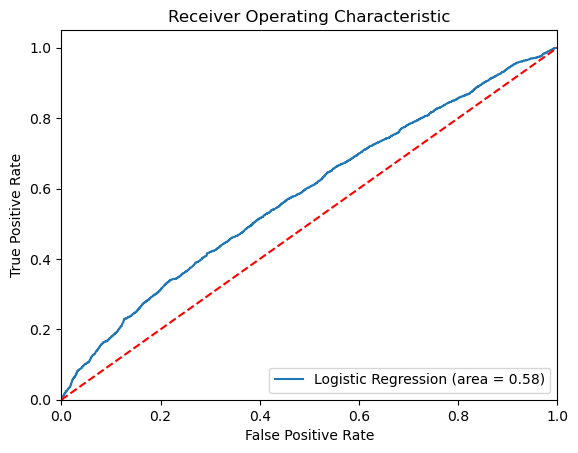

In [110]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr3, tpr3, label='Logistic Regression (area = %0.2f)' % metrics.auc(fpr3, tpr3))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### From these results, we'd draw that the first 2 models are near equivalent in predictive power yet the second is more parsimonious. Therefore, we decide to choose the second model (signficant features) as our final model.

## Best Model Summary
### (Significant AUC Model)

In [111]:
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 arrest   No. Observations:               161057
Model:                            GLM   Df Residuals:                   161052
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -40677.
Date:                Fri, 09 Dec 2022   Deviance:                       81355.
Time:                        16:03:34   Pearson chi2:                 1.63e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1802
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
district         0.3275      0.032     10.097      0.000       0.264       0.391
x_coordinate -1.781e-06   8.38e-09   -212.460      0.000    -1.8e-06   -1.76e-06
domestic         1.1197      0.154      7.285      0.000       0.818       1.421
primary_type     0.9950      0.007    137.915      0.000       0.981       1.009
month            0.6415      0.057     11.315      0.000       0.530       0.753
================================================================================
"""